# 6.3 Geospatial Analysis

## Contents

1. Importing libraries and data
2. Data Wrangling
    - deriving ['estimated_occupancy']
    - deriving ['EROR'], or Estimated by Reviews Occupancy Range
    - deriving ['estimated_revenue']
3. Pre-Cloropleth data cleaning
4. Plotting a cloropleth

## 1. Importing Standard DA Libraries, Visualization Libraries + Libraries for Geospatial Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
import folium
import json

In [2]:
%matplotlib inline

# This command prompts matplotlib visuals to appear in the notebook

In [3]:
atxgeo = r'/Users/jeremyobach/Documents/Data Analytics/CareerFoundry/Achievement 6 - Self Designed Project/Austin Airbnb Project - MASTER FOLDER/02 Data/Inside Airbnb/Austin.neighbourhoods.geojson'

In [4]:
atxgeo

'/Users/jeremyobach/Documents/Data Analytics/CareerFoundry/Achievement 6 - Self Designed Project/Austin Airbnb Project - MASTER FOLDER/02 Data/Inside Airbnb/Austin.neighbourhoods.geojson'

In [5]:
#Setting path to Achievement 6 master folder
path = r'/Users/jeremyobach/Documents/Data Analytics/CareerFoundry/Achievement 6 - Self Designed Project/Austin Airbnb Project - MASTER FOLDER'
#checking path set correctly
path

'/Users/jeremyobach/Documents/Data Analytics/CareerFoundry/Achievement 6 - Self Designed Project/Austin Airbnb Project - MASTER FOLDER'

In [6]:
# delimiting columns displayed
pd.options.display.max_columns = None

In [7]:
listings = pd.read_csv(os.path.join(path,'02 Data', 'Prepared Data','listings_entirespace.csv'), index_col = False)

In [8]:
listings.shape

(8764, 56)

In [9]:
listings.head()

,Unnamed: 0,id,listing_url,host_id,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,host_listings,host_entire_homes,host_private_rooms,host_shared_rooms,reviews_per_month,Bathroom_Numeric,Bathroom_String
0,0,5456,https://www.airbnb.com/rooms/5456,8028,2009-02-16,100%,97%,True,East Downtown,1.0,"['email', 'phone']",t,t,78702,30.26057,-97.73441,Entire guesthouse,Entire home/apt,3,1 bath,NaN,2.0,[],$101.00,2,90,2,2,90,90,2.0,t,21,51,74,330,668,47,1,2009-03-08,2023-11-20,4.84,4.88,4.86,4.89,4.83,4.73,4.79,f,1,1,0,0,3.71,1.0,NaN
1,3,6448,https://www.airbnb.com/rooms/6448,14156,2009-04-20,100%,100%,True,Zilker,1.0,"['email', 'phone']",t,t,78704,30.26034,-97.76487,Entire guesthouse,Entire home/apt,2,1 bath,NaN,2.0,[],$159.00,3,365,3,3,1125,1125,3.0,t,10,10,16,160,312,21,2,2011-09-06,2023-12-04,4.97,4.97,4.96,4.99,4.97,4.97,4.89,t,1,1,0,0,2.09,1.0,NaN
2,4,8502,https://www.airbnb.com/rooms/8502,25298,2009-07-11,100%,50%,True,East Riverside,1.0,"['email', 'phone']",t,f,78741,30.23466,-97.73682,Entire guest suite,Entire home/apt,2,1 bath,NaN,1.0,[],$48.00,4,90,4,20,90,90,7.2,t,15,45,75,75,51,3,0,2010-02-19,2023-05-16,4.56,4.52,4.70,4.84,4.87,4.67,4.60,f,1,1,0,0,0.30,1.0,NaN
3,5,13035,https://www.airbnb.com/rooms/13035,50793,2009-11-02,100%,93%,True,East Downtown,2.0,"['email', 'phone']",t,t,78702,30.26098,-97.73072,Entire home,Entire home/apt,3,2 baths,NaN,2.0,[],$123.00,30,180,30,30,180,180,30.0,t,0,0,0,201,18,1,0,2011-03-16,2023-06-19,5.00,4.94,4.94,5.00,5.00,5.00,4.94,f,2,2,0,0,0.12,2.0,s
4,6,18258,https://www.airbnb.com/rooms/18258,39458,2009-09-18,100%,96%,True,NaN,1.0,"['email', 'phone']",t,t,78745,30.19756,-97.78754,Entire bungalow,Entire home/apt,2,2 baths,NaN,2.0,[],$100.00,3,30,3,3,1125,1125,3.0,t,0,0,0,0,20,18,1,2022-10-25,2023-11-22,5.00,5.00,5.00,5.00,5.00,4.60,4.95,f,1,1,0,0,1.44,2.0,s


## 2. Data Wrangling

- Since we don't have an outright revenue column, we can derive it borrowing from the methodology outlined in Inside Airbnb's assumptions page: http://insideairbnb.com/data-assumptions/.

- We'll derive an ['estimated occupancy'] metric by dividing ['reviews_per_month'] by 50% (in other words x2), times the minimum length of stay if greater than 3 nights, and capped at 3 if minimum stay lower than 3 nights.
    - not every guest will review. Airbnb CEO Brian Chesky uses 72% metric, which is likely optomistic; New York attourney general uses review rate of 30.5%. Inside Airbnb opted to split the difference with a 50% reviews to estimated bookings rate.
    - listings.csv dataset offers several 'minimum nights' metrics, including:
        - 'minimum nights', minimum night stay for the listing 
        - 'minimum_minimum_nights', the smallest minimum_night value from the calender (looking 365 nights in the future)
        - 'maximum_minimum_nights' the largest minimum_night value from the calender (looking 365 nights in the future),
        - minimum_nights_avg_ntm, the average minimum_night value from the calender (looking 365 nights in the future)
    - opting to use 'minimum_nights_avg_ntm' for occupancy calculations. It may be slightly more accurate than 'minimum nights'
    - ['estimated_occupancy'] capped at 30 days for full occupancy.
        - Inside Airbnb caps occupancy at 70% to remain conservative; their goal is to demonstrate the effect which Airbnb's might impact the local housing supply.
    
- Next we'll derive ['estimated revenue'] by multiplying ['price'] (*which can be changed by the host on a given date but for our purposes will remain static*) times ['estimated occupancy'].

/Users/jeremyobach/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeremyobach/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='reviews_per_month', ylabel='Count'>

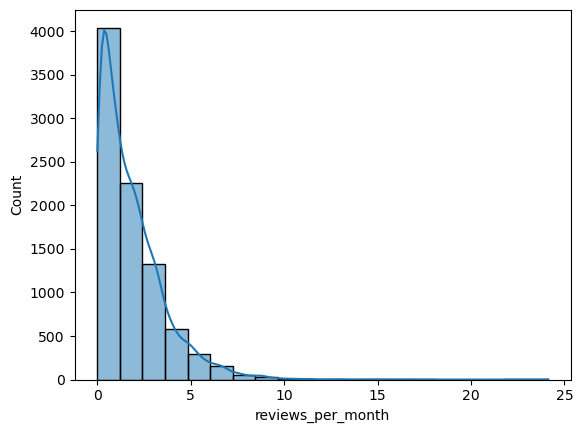

In [10]:
sns.histplot(listings['reviews_per_month'], bins = 20, kde = True)

In [11]:
listings['reviews_per_month'].value_counts()

reviews_per_month
1.00     130
0.07      78
0.14      70
0.04      69
0.55      66
        ... 
12.26      1
5.96       1
10.53      1
8.94       1
7.00       1
Name: count, Length: 773, dtype: int64

In [11]:
# Creating estimated occupancy variable

listings['estimated_occupancy'] = listings['reviews_per_month']* 2 * listings['minimum_nights_avg_ntm'].apply(lambda x: x if x >= 3 else 3)

In [14]:
# capping estimated_occupancy at 30
listings['estimated_occupancy'] = listings['estimated_occupancy'].apply(lambda x: min(x, 30))

In [16]:


listings['estimated_occupancy'].value_counts(ascending = True, sort = False, dropna = True)

estimated_occupancy
22.260    12
12.540    20
4.320     19
7.200     32
8.640     15
          ..
12.740     1
23.600     1
5.848      1
17.538     1
7.400      1
Name: count, Length: 1271, dtype: int64

/Users/jeremyobach/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeremyobach/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='estimated_occupancy', ylabel='Count'>

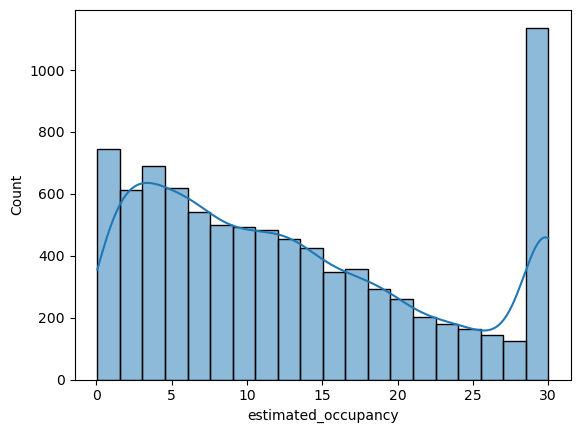

In [18]:
# Update: Shifting estimated_occupancy to factor in minimum stay vs a cap at 3 days greatly impacted the proportion of occupancy across the buckets.

sns.histplot(listings['estimated_occupancy'], bins = 20, kde = True)

In [19]:
listings['estimated_occupancy'].value_counts()

estimated_occupancy
30.000    1034
6.000       98
12.000      51
18.000      51
3.300       50
          ... 
2.660        1
4.488        1
1.534        1
2.500        1
7.400        1
Name: count, Length: 1271, dtype: int64

In [21]:
# Creating Estimated by Reviews Occupancy Range (EROR)

listings.loc[listings['estimated_occupancy'] < 2, 'EROR'] = 'Very low occupancy'
listings.loc[(listings['estimated_occupancy'] >= 2) & (listings['estimated_occupancy'] < 7),'EROR'] = 'Low occupancy'
listings.loc[(listings['estimated_occupancy'] >= 7) & (listings['estimated_occupancy'] < 30),'EROR'] = 'Medium occupancy'
listings.loc[listings['estimated_occupancy'] >= 30, 'EROR'] = 'High occupancy'


In [18]:
listings['EROR'].value_counts(dropna = False)

EROR
Medium occupancy      4790
Low occupancy         2647
Very low occupancy     814
High occupancy         513
Name: count, dtype: int64

### Deriving Estimated Revenue

Need to clean ['price'] variable:
- remove dollar sign, change to float64
- will also remove outliers.

In [22]:
listings['price'].dtype

dtype('O')

In [23]:
listings['price'] = listings['price'].str.replace(',','')
listings['price'] = listings['price'].str.replace('$','')
listings['price'] = listings['price'].astype(float)

In [24]:
# Removing price outliers, which throw est_rev bins out of whack

q = listings['price'].quantile(0.99)

In [25]:
listings = listings[listings['price']<q]

In [26]:
listings['estimated_revenue'] = listings['estimated_occupancy']*listings['price']

In [27]:
listings.head()

,Unnamed: 0,id,listing_url,host_id,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,host_listings,host_entire_homes,host_private_rooms,host_shared_rooms,reviews_per_month,Bathroom_Numeric,Bathroom_String,estimated_occupancy,EROR,estimated_revenue
0,0,5456,https://www.airbnb.com/rooms/5456,8028,2009-02-16,100%,97%,True,East Downtown,1.0,"['email', 'phone']",t,t,78702,30.26057,-97.73441,Entire guesthouse,Entire home/apt,3,1 bath,NaN,2.0,[],101.0,2,90,2,2,90,90,2.0,t,21,51,74,330,668,47,1,2009-03-08,2023-11-20,4.84,4.88,4.86,4.89,4.83,4.73,4.79,f,1,1,0,0,3.71,1.0,NaN,22.26,Medium occupancy,2248.26
1,3,6448,https://www.airbnb.com/rooms/6448,14156,2009-04-20,100%,100%,True,Zilker,1.0,"['email', 'phone']",t,t,78704,30.26034,-97.76487,Entire guesthouse,Entire home/apt,2,1 bath,NaN,2.0,[],159.0,3,365,3,3,1125,1125,3.0,t,10,10,16,160,312,21,2,2011-09-06,2023-12-04,4.97,4.97,4.96,4.99,4.97,4.97,4.89,t,1,1,0,0,2.09,1.0,NaN,12.54,Medium occupancy,1993.86
2,4,8502,https://www.airbnb.com/rooms/8502,25298,2009-07-11,100%,50%,True,East Riverside,1.0,"['email', 'phone']",t,f,78741,30.23466,-97.73682,Entire guest suite,Entire home/apt,2,1 bath,NaN,1.0,[],48.0,4,90,4,20,90,90,7.2,t,15,45,75,75,51,3,0,2010-02-19,2023-05-16,4.56,4.52,4.70,4.84,4.87,4.67,4.60,f,1,1,0,0,0.30,1.0,NaN,4.32,Low occupancy,207.36
3,5,13035,https://www.airbnb.com/rooms/13035,50793,2009-11-02,100%,93%,True,East Downtown,2.0,"['email', 'phone']",t,t,78702,30.26098,-97.73072,Entire home,Entire home/apt,3,2 baths,NaN,2.0,[],123.0,30,180,30,30,180,180,30.0,t,0,0,0,201,18,1,0,2011-03-16,2023-06-19,5.00,4.94,4.94,5.00,5.00,5.00,4.94,f,2,2,0,0,0.12,2.0,s,7.20,Medium occupancy,885.60
4,6,18258,https://www.airbnb.com/rooms/18258,39458,2009-09-18,100%,96%,True,NaN,1.0,"['email', 'phone']",t,t,78745,30.19756,-97.78754,Entire bungalow,Entire home/apt,2,2 baths,NaN,2.0,[],100.0,3,30,3,3,1125,1125,3.0,t,0,0,0,0,20,18,1,2022-10-25,2023-11-22,5.00,5.00,5.00,5.00,5.00,4.60,4.95,f,1,1,0,0,1.44,2.0,s,8.64,Medium occupancy,864.00


In [28]:
listings['estimated_revenue'].value_counts(dropna = False)

estimated_revenue
2700.00    26
2850.00    26
3000.00    24
2970.00    21
2100.00    19
           ..
1481.76     1
6582.96     1
205.00      1
1305.30     1
495.80      1
Name: count, Length: 6668, dtype: int64

/Users/jeremyobach/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeremyobach/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='estimated_revenue', ylabel='Count'>

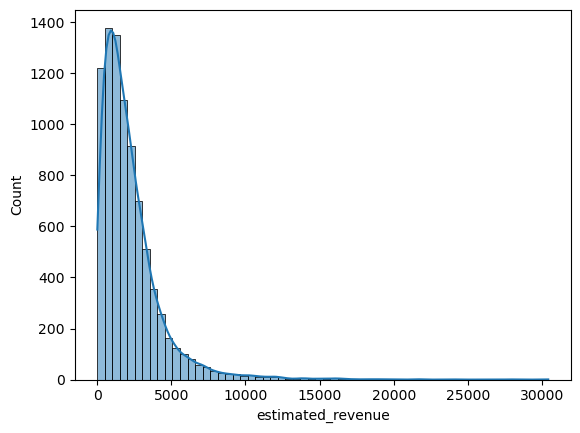

In [41]:
sns.histplot(listings['estimated_revenue'], bins = 60, kde = True)

### 3. Data Cleaning

- as mentioned, data cleaning for price is above.
- Will remove lower outliers for reviews per month as well.

In [30]:
listings['reviews_per_month'].value_counts(ascending = True)

reviews_per_month
7.00       1
9.91       1
24.13      1
6.11       1
6.92       1
        ... 
0.55      65
0.04      66
0.14      67
0.07      77
1.00     130
Name: count, Length: 773, dtype: int64

In [31]:
z = listings['reviews_per_month'].quantile(0.01)

In [32]:
listings = listings[listings['reviews_per_month']>z]

In [33]:
listings.shape

(8576, 59)

In [34]:
# Verifying dtype for the key to the json

listings['neighbourhood_cleansed'].dtype

dtype('int64')

### 4. Plotting a chloropleth

In [35]:
# Create a df with just the neighborhoods and values for rating we want plotted

zip_by_revenue = listings[['neighbourhood_cleansed', 'estimated_revenue']]
zip_by_revenue.head()

,neighbourhood_cleansed,estimated_revenue
0,78702,2248.26
1,78704,1993.86
2,78741,207.36
3,78702,885.60
4,78745,864.00


In [36]:
listings['estimated_revenue'].dtype

dtype('float64')

In [37]:
# Finding GeoJSON keys



In [38]:
# Setup a folium map at Austin TX
map = folium.Map(location = [30.2666, -97.73330], zoom_start = 9)

# Choropleth maps bind Pandas Data Frames and json geometries.This allows us to quickly visualize data combinations
folium.Choropleth(
    geo_data = atxgeo, 
    data = zip_by_revenue,
    columns = ['neighbourhood_cleansed', 'estimated_revenue'],
    key_on = "feature.properties.neighbourhood",
    fill_color = 'YlOrBr', fill_opacity=0.6, line_opacity=0.1,
    legend_name = "estimated revenue").add_to(map)
folium.LayerControl().add_to(map)

map


### Results analysis:

The neighborhoods in this dataset are just the boundaries of the various zipcodes in ATX, so not as granular as I would hope BUT... this does answer some research questions I posed at the outset of the analysis. 

In particular, where are the highest earning listings in Austin Texas. Need to figure out how to do an overlay so I don't mistakenly crossreference these neighborhoods versus this map I'm using for reference.

78746 being darker/ in the 3000+ range makes sense, with its large swathe on the River, but the dark spot north of downtown and West Campus, what looks like 78757, not clear what set this neighborhood aside as such an outlier earner, with an average of over 5000 in revenue per month. Will investigate further if it's due to a few high earning outliers (even though we cleaned the data of the top 1% of listings by price), or if there's really just a hot spot there for whatever reason.

The next one that jumps out is at the north of the greater Austin metroplex, pretty firmly in Round Rock at 78717. Appears to be relatively affluent, suburban - again we would have to drill into the listings data to discover whether or not the darker cloropleth shade is due to a few high earners with few average/low earning listings, or some alternative.

Interesting stuff though! Lots of research to do about the various zip codes in regards to income, 'fun factor', and airbnb inventory.

*UPDATE*: Implemented the more nuanced 'estimated_occupancy' to include the minimum stay as a factor when greater than 3 days. Made a big impact, moving a lot of very low review counts out of the <1 day bucket and into others to the right. Furthermore, this had a redistributing affect on estimated_revenue as well, moving a lot of estimated revenue figures up.

In [42]:
listings.to_csv(os.path.join(path,'02 Data', 'Prepared Data','listings_63.csv'))